# Repare dataset

## txt2csv

In [1]:
import re
import csv

input_file = './dataset/ps_encodedcommand_data.txt'
output_file = './dataset/ps_encodedcommand_data.csv'

with open(input_file, 'rb') as file:
    content = file.read()

content_str = content.decode('latin-1')

pattern = re.compile(
        r'######################### START #########################(.*?)#########################  END  #########################',
    re.DOTALL
)

matches = pattern.findall(content_str)

data_list = []

for match in matches:
    original_code = re.search(r'\[Original Code\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    filename = re.search(r'\[Filename\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    arguments = re.search(r'\[Arguments\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    b64_decoded = re.search(r'\[B64 Decoded\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    family_name = re.search(r'\[Family Name\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()

    data = {
        'Original Code': original_code,
        'Filename': filename, 
        'Arguments': arguments,
        'B64 Decoded': b64_decoded,
        'Family Name': family_name
    }
    data_list.append(data)

with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Original Code', 'Filename', 'Arguments', 'B64 Decoded', 'Family Name']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for data in data_list:
        writer.writerow(data)

print(f'Data has been written to {output_file}')

Data has been written to ./dataset/ps_encodedcommand_data.csv


## preprocess CSV

In [2]:
import pandas as pd
import re
from dataclasses import replace

input_file = './dataset/ps_encodedcommand_data.csv'
output_file = './dataset/data_processed.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

# print(df.head())

def extract_executable(input_string):
    pattern = re.compile(r'\\\"(.*?)\\\"|(\S+\.exe)|\bpowershell\b', re.IGNORECASE)
    match = pattern.search(input_string)
    if match:
        if match.group(1):
            result = match.group(1)
        elif match.group(2):
            result = match.group(2)
        else:
            result = match.group(0)
        result = result.replace('"', '')
        return result
    return None

# Áp dụng hàm extract_executable lên cột 'Original Code' và tạo cột mới 'Path Exec'
df['Path Exec'] = df['Original Code'].apply(extract_executable)

# print(df.head())

def combine_attributes(row):
    Path_Exec = str(row['Path Exec'])
    Arguments = re.sub(r"[\[\]',]", '', str(row['Arguments']))
    Payload = str(row['B64 Decoded'])

    combine_value = f'{Path_Exec} {Arguments} {Payload}'
    return combine_value

df['Full Payload'] = df.apply(combine_attributes, axis=1)
print(df['Family Name'].unique())

['Shellcode Inject' 'Downloader DFSP' 'Powerfun Reverse' 'SET'
 'Downloader DFSP 2X' 'Unicorn' 'PowerShell Empire' 'Downloader Proxy'
 'Meterpreter RHTTP' 'Scheduled Task COM' 'Downloader IEXDS' 'Unknown'
 'AMSI Bypass' 'VB Task' 'Veil Stream' 'PowerWorm' 'Remote DLL'
 'Downloader Kraken' 'TXT C2' 'BITSTransfer' 'Downloader DFSP DPL'
 'Powerfun Bind' 'Unicorn Modified' 'PowerSploit GTS' 'DynAmite Launcher'
 'Remove AV' 'DynAmite KL']


## Combine Family name to label

In [3]:
import pandas as pd

input_file = './dataset/data_processed.csv'
output_file = './dataset/data_labeled.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

def map_family_to_label(family_name):
    if pd.isnull(family_name):
        return 'Unknown'

    family_name = family_name.lower()

    # Bypass
    if 'bypass' in family_name or 'remove av' in family_name:
        return 'Bypass'

    # TaskExecution
    elif 'task' in family_name or 'scheduled' in family_name or 'com' in family_name \
        or 'bits' in family_name or 'vb task' in family_name \
        or 'dynamite' in family_name:
        return 'TaskExecution'

    # Downloader
    elif 'downloader' in family_name or 'transfer' in family_name or 'proxy' in family_name \
        or 'iexds' in family_name or 'dfsp' in family_name:
        return 'Downloader'

    # Injector
    elif 'inject' in family_name or 'trojan' in family_name or 'shellcode' in family_name \
        or 'remote dll' in family_name or 'rhttp' in family_name \
        or ('unicorn' in family_name and 'modified' in family_name):
        return 'Injector'

    # Payload
    elif 'power' in family_name or 'empire' in family_name or 'veil' in family_name \
        or 'txt c2' in family_name or ('unicorn' in family_name and 'modified' not in family_name):
        return 'Payload'

    else:
        return 'Unknown'

# Gán nhãn
df['Label'] = df['Family Name'].apply(map_family_to_label)

# Loại bỏ 'Unknown'
row_before = len(df)
df = df[df['Label'] != 'Unknown']
row_after = len(df)
row_removed = row_before - row_after
print(f'Number of rows removed: {row_removed}')

# Thống kê số lượng nhãn
label_counts = df['Label'].value_counts()
print('Label counts:')
print(label_counts)

# Thống kê tỷ lệ phần trăm
label_percentages = (label_counts / len(df)) * 100
print('Label percentages:')
print(label_percentages)

# Lưu file
columns_to_keep = ['Full Payload', 'Label']
df = df[columns_to_keep]
df.to_csv(output_file, index=False)
print(f'DataFrame has been written to {output_file}')


Number of rows removed: 303
Label counts:
Label
Downloader       1511
Injector         1171
Payload          1045
TaskExecution      39
Bypass             10
Name: count, dtype: int64
Label percentages:
Label
Downloader       40.015890
Injector         31.011653
Payload          27.674788
TaskExecution     1.032839
Bypass            0.264831
Name: count, dtype: float64
DataFrame has been written to ./dataset/data_labeled.csv


# extend dataset


📊 Phân phối nhãn trong dataset gốc:
Label
Downloader       1511
Injector         1171
Payload          1045
TaskExecution      39
Bypass             10
Name: count, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/amsi_fail.csv):
Label
Bypass    965
Name: count, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/Malicious-PowerShell-Dataset_bazaar_out.csv):
Label
Payload          401
TaskExecution     72
Injector           4
Bypass             1
Name: count, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/Malicious-PowerShell-Dataset_hybrid_analysis_out.csv):
Label
Payload          70
TaskExecution    37
Bypass            2
Name: count, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/Malicious-PowerShell-Dataset_triage_out.csv):
Label
Payload          322
TaskExecution    130
Bypass             2
Injector           1
Name: count, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/mpsd.csv):
Label
Payload          1003
Task

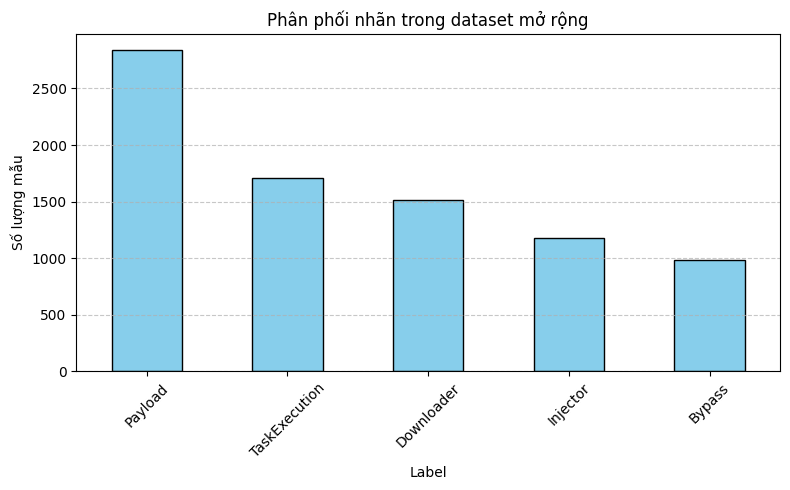


✅ Kiểm tra null sau khi lưu:
Full Payload    0
Label           0
dtype: int64

🔍 Các dòng có Label null:
Empty DataFrame
Columns: [Full Payload, Label]
Index: []

🔍 Các dòng có Label là 'nan' (string):
Empty DataFrame
Columns: [Full Payload, Label]
Index: []

🔍 Các dòng có Label là chuỗi rỗng:
Empty DataFrame
Columns: [Full Payload, Label]
Index: []


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== Các nhãn hợp lệ theo PowerDetector =====
VALID_LABELS = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}

def load_and_standardize_csv(file_path):
    """
    Chuẩn hóa dữ liệu từ file CSV:
    - Đổi tên 'Payload' thành 'Full Payload' nếu cần.
    - Loại bỏ NaN và chuỗi 'nan' ở cột Label.
    - Chuẩn hóa và lọc nhãn hợp lệ.
    """
    df = pd.read_csv(file_path)

    if 'Full Payload' not in df.columns and 'Payload' in df.columns:
        df.rename(columns={'Payload': 'Full Payload'}, inplace=True)

    if 'Full Payload' not in df.columns or 'Label' not in df.columns:
        print(f"⚠️ File {file_path} không hợp lệ (thiếu 'Full Payload' hoặc 'Label'). Bỏ qua.")
        return pd.DataFrame()

    df.dropna(subset=['Label'], inplace=True)
    df['Label'] = df['Label'].astype(str).str.strip()
    df = df[df['Label'].str.lower() != 'nan']

    df = df[df['Label'].isin(VALID_LABELS)]

    return df[['Full Payload', 'Label']]

# ===== Main script =====
base_dataset = './dataset/data_labeled.csv'
new_dataset_files = [
    './dataset_extra/dataset/amsi_fail.csv',
    './dataset_extra/dataset/Malicious-PowerShell-Dataset_bazaar_out.csv',
    './dataset_extra/dataset/Malicious-PowerShell-Dataset_hybrid_analysis_out.csv',
    './dataset_extra/dataset/Malicious-PowerShell-Dataset_triage_out.csv',
    './dataset_extra/dataset/mpsd.csv',
    './dataset_extra/dataset/task_exec_from_atomic.csv',
]
output_dataset = './dataset/data_labeled_extended.csv'

df_base = load_and_standardize_csv(base_dataset)
print("\n📊 Phân phối nhãn trong dataset gốc:")
print(df_base['Label'].value_counts())

for file_path in new_dataset_files:
    df_new = load_and_standardize_csv(file_path)
    if not df_new.empty:
        print(f"\n📊 Phân phối nhãn (file: {file_path}):")
        print(df_new['Label'].value_counts())
        df_base = pd.concat([df_base, df_new], ignore_index=True)

# ✅ Lọc kỹ dữ liệu trước khi lưu
df_base['Label'] = df_base['Label'].astype(str).str.strip()
df_base = df_base[
    df_base['Label'].notna() &
    (df_base['Label'].str.lower() != 'nan') &
    (df_base['Label'].str.strip() != '')
]

# 🚨 Lọc dòng nhãn bị lệch cột: Label NaN nhưng Full Payload là tên nhãn
df_base = df_base[~(
    df_base['Label'].isnull() & df_base['Full Payload'].isin(VALID_LABELS)
)]

# 💾 Ghi ra file
df_base.to_csv(output_dataset, index=False)
print(f"\n💾 Dataset mở rộng đã lưu vào: {output_dataset}")

# 📊 Thống kê và biểu đồ
label_counts = df_base['Label'].value_counts()
print("\n📊 Phân phối nhãn sau khi nối:")
print(label_counts)

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Phân phối nhãn trong dataset mở rộng')
plt.xlabel('Label')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 🔍 Kiểm tra kỹ sau khi lưu
df_check = pd.read_csv(output_dataset)
print("\n✅ Kiểm tra null sau khi lưu:")
print(df_check.isnull().sum())

print("\n🔍 Các dòng có Label null:")
print(df_check[df_check['Label'].isnull()])

print("\n🔍 Các dòng có Label là 'nan' (string):")
print(df_check[df_check['Label'].astype(str).str.lower() == 'nan'])

print("\n🔍 Các dòng có Label là chuỗi rỗng:")
print(df_check[df_check['Label'].astype(str).str.strip() == ''])


In [5]:
import pandas as pd

df = pd.read_csv('./dataset/data_labeled_extended.csv')

null_columns = df.columns[df.isnull().any()]

if not null_columns.empty:
    print("Các cột chứa giá trị null:")
    print(null_columns)
else:
    print("Không có cột nào chứa giá trị null.")

Không có cột nào chứa giá trị null.


# Full Payload length

## Analyze


📏 Thống kê chiều dài 'Full Payload':
count    8.220000e+03
mean     5.326412e+04
std      3.510060e+05
min      1.000000e+00
25%      2.010000e+02
50%      1.273000e+03
75%      2.356000e+03
max      8.108582e+06
Name: Payload Length, dtype: float64


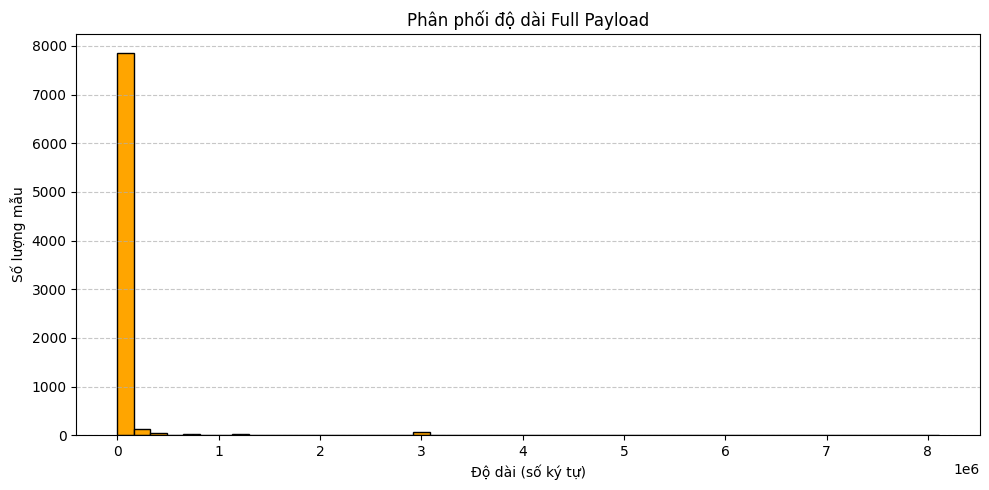


🎯 Ngưỡng 95%: 72828 ký tự
🎯 Ngưỡng 99%: 2581154 ký tự


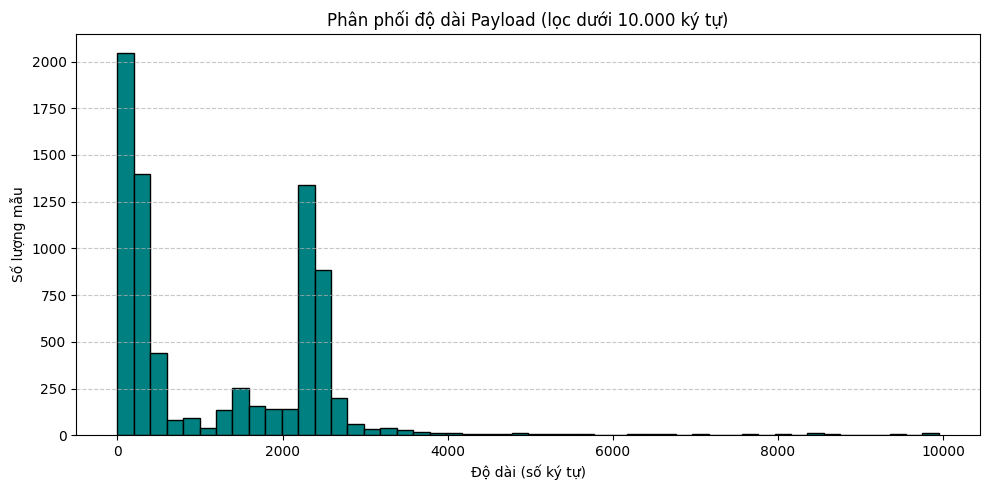

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn file CSV đã được lưu trước đó
input_dataset = './dataset/data_labeled_extended.csv'

# Đọc file CSV
df = pd.read_csv(input_dataset)

# Tính độ dài chuỗi Full Payload
df['Payload Length'] = df['Full Payload'].astype(str).apply(len)

# Hiển thị thống kê mô tả
print("\n📏 Thống kê chiều dài 'Full Payload':")
print(df['Payload Length'].describe())

# Vẽ biểu đồ histogram phân phối độ dài
plt.figure(figsize=(10, 5))
plt.hist(df['Payload Length'], bins=50, color='orange', edgecolor='black')
plt.title('Phân phối độ dài Full Payload')
plt.xlabel('Độ dài (số ký tự)')
plt.ylabel('Số lượng mẫu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ===== Đề xuất giới hạn độ dài =====
threshold_95 = df['Payload Length'].quantile(0.95)
threshold_99 = df['Payload Length'].quantile(0.99)

print(f"\n🎯 Ngưỡng 95%: {int(threshold_95)} ký tự")
print(f"🎯 Ngưỡng 99%: {int(threshold_99)} ký tự")

# Vẽ biểu đồ tập trung vào phần lớn dữ liệu (dưới 10.000 ký tự)
plt.figure(figsize=(10, 5))
plt.hist(df[df['Payload Length'] < 10000]['Payload Length'], bins=50, color='teal', edgecolor='black')
plt.title('Phân phối độ dài Payload (lọc dưới 10.000 ký tự)')
plt.xlabel('Độ dài (số ký tự)')
plt.ylabel('Số lượng mẫu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Clean dataset


✂️ Đã loại bỏ 538 dòng có Full Payload dài hơn 10000 ký tự.
✅ Dataset sau khi cắt còn lại: 7682 dòng.

📊 Phân phối nhãn sau khi cắt:
Label
Payload          2427
TaskExecution    1587
Downloader       1511
Injector         1178
Bypass            979
Name: count, dtype: int64


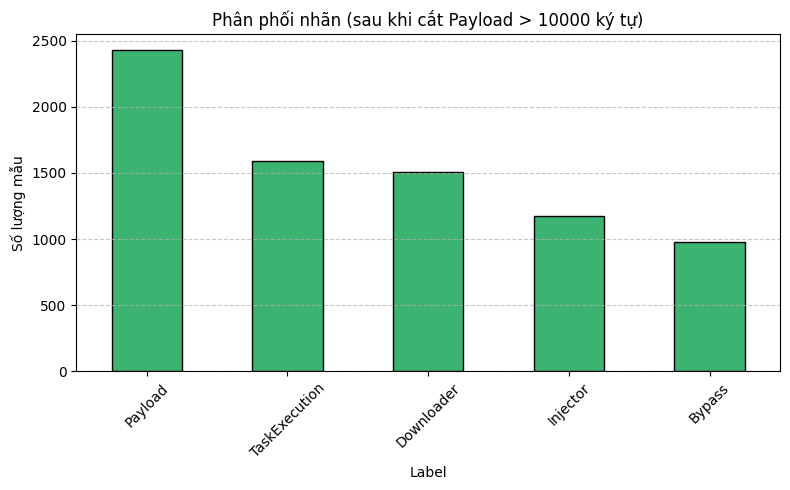


💾 File đã lưu: ./dataset/data_labeled_extended.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== Tham số =====
input_file = './dataset/data_labeled_extended.csv'
output_file = input_file
max_length = 10000  # Ngưỡng giới hạn độ dài Full Payload

# ===== Đọc dữ liệu =====
df = pd.read_csv(input_file)
df['Payload Length'] = df['Full Payload'].astype(str).apply(len)

# ===== Cắt dữ liệu theo ngưỡng =====
initial_count = len(df)
df_truncated = df[df['Payload Length'] <= max_length].copy()
removed_count = initial_count - len(df_truncated)

# ===== Kết quả =====
print(f"\n✂️ Đã loại bỏ {removed_count} dòng có Full Payload dài hơn {max_length} ký tự.")
print(f"✅ Dataset sau khi cắt còn lại: {len(df_truncated)} dòng.")

# ===== Phân phối nhãn =====
label_counts = df_truncated['Label'].value_counts()
print("\n📊 Phân phối nhãn sau khi cắt:")
print(label_counts)

# ===== Biểu đồ =====
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title(f'Phân phối nhãn (sau khi cắt Payload > {max_length} ký tự)')
plt.xlabel('Label')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ===== Lưu dữ liệu mới =====
df_truncated = df_truncated[['Full Payload', 'Label']]  # Giữ lại 2 cột chính
df_truncated.to_csv(output_file, index=False)
print(f"\n💾 File đã lưu: {output_file}")


## deobfuscate 3 layer

In [8]:
import pandas as pd
import re

# ===== LIGHT DEOBFUSCATION LOGIC =====
def remove_comments(script: str) -> str:
    return re.sub(r'#.*', '', script)

def flatten_string_operations(script: str) -> str:
    pattern = r'"([^"]+)"\s*\+\s*"([^"]+)"'
    while re.search(pattern, script):
        script = re.sub(pattern, lambda m: '"' + m.group(1) + m.group(2) + '"', script)
    return script

def simplify_token_obfuscation(script: str) -> str:
    # Placeholder cho dynamic execution: .(...) → Invoke-Expression
    pattern = r"\.\s*\(\s*\$?[a-zA-Z0-9\+\[\]\.\(\)'\" _-]+\s*\)"
    script = re.sub(pattern, 'Invoke-Expression', script, flags=re.IGNORECASE)

    replacements = {
        r'\bIEX\b': 'Invoke-Expression',
        r'\bInVoKe-ExPrEsSiOn\b': 'Invoke-Expression',
        r'\bNEW-OBJECT\b': 'New-Object',
        r'\bNeW-ObJeCt\b': 'New-Object',
        r'\bSPlit\b': 'Split',
        r'\bJoin\b': 'Join'
    }
    for pattern, replacement in replacements.items():
        script = re.sub(pattern, replacement, script, flags=re.IGNORECASE)

    return script

def light_deobfuscate(script: str) -> str:
    script = remove_comments(script)
    script = flatten_string_operations(script)
    script = simplify_token_obfuscation(script)
    return script

# ===== APPLY TO CSV =====
input_file = './dataset/data_labeled_extended.csv'

try:
    df = pd.read_csv(input_file)
except Exception as e:
    print(f"❌ Error reading {input_file}: {e}")
    exit()

# Deobfuscate từng dòng và ghi đè vào cột Full Payload
print("🔁 Deobfuscating and overwriting Full Payload...")
df['Full Payload'] = df['Full Payload'].fillna('').apply(light_deobfuscate)

# Ghi đè lại file cũ
df.to_csv(input_file, index=False)
print(f"✅ Done. Updated file saved to: {input_file}")


🔁 Deobfuscating and overwriting Full Payload...
✅ Done. Updated file saved to: ./dataset/data_labeled_extended.csv


In [9]:
print(df.columns)


Index(['Full Payload', 'Label'], dtype='object')


# Extract vector

## rela2vec

In [10]:
import pandas as pd
import spacy
import networkx as nx
import pickle
import numpy as np
import os
from node2vec import Node2Vec
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# ================== CONFIG ==================
input_file = './dataset/data_labeled_extended.csv'
output_file = input_file
rela2vec_dir = './vectorization/rela2vec'
graphs_file = os.path.join(rela2vec_dir, 'semantic_graph_extended.pkl')
os.makedirs(rela2vec_dir, exist_ok=True)

# ============= LOAD DATA =============
df = pd.read_csv(input_file)

if 'Rela2Vec' not in df.columns:
    df['Rela2Vec'] = ''
else:
    df['Rela2Vec'] = df['Rela2Vec'].astype(str)

# ============= BUILD GRAPHS =============
def build_graph(idx, payload):
    try:
        nlp = spacy.load("en_core_web_sm")
        nlp.max_length = 20_000_000  # hỗ trợ văn bản dài
        doc = nlp(payload)
        G = nx.Graph()

        for ent in doc.ents:
            G.add_node(ent.text, type=ent.label_)

        for sent in doc.sents:
            ents = [ent.text for ent in sent.ents]
            for i in range(len(ents)):
                for j in range(i + 1, len(ents)):
                    G.add_edge(ents[i], ents[j])

        return idx, G
    except Exception as e:
        print(f"❌ Error building graph at idx={idx}: {e}")
        return idx, nx.Graph()

if os.path.exists(graphs_file):
    print(f"✅ Found existing semantic graph at {graphs_file}. Loading...")
    with open(graphs_file, 'rb') as f:
        graphs = pickle.load(f)
else:
    print("⏳ No existing graph found. Building semantic graphs in parallel...")
    full_payloads = df['Full Payload'].dropna()
    graphs = {}

    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = {executor.submit(build_graph, idx, payload): idx for idx, payload in full_payloads.items()}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Building Graphs (Parallel)"):
            idx, G = future.result()
            graphs[idx] = G

    with open(graphs_file, 'wb') as f:
        pickle.dump(graphs, f)
    print(f"✅ Saved semantic graphs to {graphs_file}")

# ============= EMBEDDING =============
def embed_graph(idx, graph_data):
    try:
        G = graph_data
        if G is None or len(G.nodes) == 0:
            return idx, ' '.join(['0'] * 128)

        node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4, quiet=True)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        node_embeddings = model.wv
        vec = np.mean([node_embeddings[node] for node in G.nodes if node in node_embeddings], axis=0)
        return idx, ' '.join(map(str, vec))
    except Exception as e:
        print(f"⚠️ Node2Vec error at idx={idx}: {e}")
        return idx, ' '.join(['0'] * 128)

missing_indices = [
    i for i in range(len(df))
    if pd.isna(df.at[i, 'Rela2Vec']) or str(df.at[i, 'Rela2Vec']).strip().lower() in ['nan', '']
]

print(f"🚀 Embedding {len(missing_indices)} graphs using ProcessPoolExecutor...")
batch_size = 100
with ProcessPoolExecutor(max_workers=16) as executor:
    futures = {executor.submit(embed_graph, idx, graphs.get(idx)): idx for idx in missing_indices}
    completed = 0

    for future in tqdm(as_completed(futures), total=len(futures), desc="Embedding (ProcessPool)"):
        idx, vec = future.result()
        df.at[idx, 'Rela2Vec'] = vec
        completed += 1

        if completed % batch_size == 0:
            df.to_csv(output_file, index=False)
            print(f"💾 Auto-saved after {completed} records.")

# ============= SAVE FINAL =============
df.to_csv(output_file, index=False)
print(f"✅ Done! Rela2Vec vectors saved to {output_file}")


⏳ No existing graph found. Building semantic graphs in parallel...


/home/ubuntu/powershell_detection_multimodel_multioutput/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Building Graphs (Parallel): 100%|██████████| 7674/7674 [07:01<00:00, 18.20it/s]


✅ Saved semantic graphs to ./vectorization/rela2vec/semantic_graph_extended.pkl
🚀 Embedding 7682 graphs using ProcessPoolExecutor...


Embedding (ProcessPool):   1%|▏         | 113/7682 [00:13<06:36, 19.10it/s]

💾 Auto-saved after 100 records.


Embedding (ProcessPool):   3%|▎         | 209/7682 [00:23<08:37, 14.43it/s]

💾 Auto-saved after 200 records.


Embedding (ProcessPool):   4%|▍         | 307/7682 [00:33<09:39, 12.72it/s]

💾 Auto-saved after 300 records.


Embedding (ProcessPool):   5%|▌         | 408/7682 [00:44<08:39, 14.01it/s]

💾 Auto-saved after 400 records.


Embedding (ProcessPool):   7%|▋         | 507/7682 [00:51<07:36, 15.73it/s]

💾 Auto-saved after 500 records.


Embedding (ProcessPool):   8%|▊         | 617/7682 [01:03<07:42, 15.27it/s]

💾 Auto-saved after 600 records.


Embedding (ProcessPool):   9%|▉         | 717/7682 [01:12<04:27, 26.00it/s]

💾 Auto-saved after 700 records.


Embedding (ProcessPool):  10%|█         | 801/7682 [01:22<22:45,  5.04it/s]

💾 Auto-saved after 800 records.


Embedding (ProcessPool):  12%|█▏        | 916/7682 [01:31<07:02, 16.01it/s]

💾 Auto-saved after 900 records.


Embedding (ProcessPool):  13%|█▎        | 1008/7682 [01:42<12:10,  9.13it/s]

💾 Auto-saved after 1000 records.


Embedding (ProcessPool):  14%|█▍        | 1111/7682 [01:51<05:29, 19.93it/s]

💾 Auto-saved after 1100 records.


Embedding (ProcessPool):  16%|█▌        | 1211/7682 [02:00<10:34, 10.21it/s]

💾 Auto-saved after 1200 records.


Embedding (ProcessPool):  17%|█▋        | 1318/7682 [02:09<07:20, 14.45it/s]

💾 Auto-saved after 1300 records.


Embedding (ProcessPool):  18%|█▊        | 1408/7682 [02:19<07:31, 13.89it/s]

💾 Auto-saved after 1400 records.


Embedding (ProcessPool):  20%|█▉        | 1506/7682 [02:29<12:58,  7.93it/s]

💾 Auto-saved after 1500 records.


Embedding (ProcessPool):  21%|██        | 1613/7682 [02:39<07:26, 13.61it/s]

💾 Auto-saved after 1600 records.


Embedding (ProcessPool):  22%|██▏       | 1706/7682 [02:49<09:44, 10.23it/s]

💾 Auto-saved after 1700 records.


Embedding (ProcessPool):  24%|██▎       | 1820/7682 [02:59<05:58, 16.33it/s]

💾 Auto-saved after 1800 records.


Embedding (ProcessPool):  25%|██▍       | 1917/7682 [03:09<05:51, 16.39it/s]

💾 Auto-saved after 1900 records.


Embedding (ProcessPool):  26%|██▌       | 2000/7682 [03:19<21:31,  4.40it/s]

💾 Auto-saved after 2000 records.


Embedding (ProcessPool):  27%|██▋       | 2112/7682 [03:29<10:08,  9.16it/s]

💾 Auto-saved after 2100 records.


Embedding (ProcessPool):  29%|██▊       | 2200/7682 [03:38<28:03,  3.26it/s]

💾 Auto-saved after 2200 records.


Embedding (ProcessPool):  30%|███       | 2306/7682 [03:46<07:51, 11.39it/s]

💾 Auto-saved after 2300 records.


Embedding (ProcessPool):  31%|███▏      | 2401/7682 [03:58<20:33,  4.28it/s]

💾 Auto-saved after 2400 records.


Embedding (ProcessPool):  33%|███▎      | 2500/7682 [04:05<13:45,  6.28it/s]

💾 Auto-saved after 2500 records.


Embedding (ProcessPool):  34%|███▍      | 2611/7682 [04:15<08:01, 10.54it/s]

💾 Auto-saved after 2600 records.


Embedding (ProcessPool):  35%|███▌      | 2727/7682 [04:25<04:16, 19.34it/s]

💾 Auto-saved after 2700 records.


Embedding (ProcessPool):  36%|███▋      | 2800/7682 [04:32<11:26,  7.12it/s]

💾 Auto-saved after 2800 records.


Embedding (ProcessPool):  38%|███▊      | 2900/7682 [04:41<17:48,  4.48it/s]

💾 Auto-saved after 2900 records.


Embedding (ProcessPool):  39%|███▉      | 3001/7682 [04:53<22:21,  3.49it/s]

💾 Auto-saved after 3000 records.


Embedding (ProcessPool):  40%|████      | 3100/7682 [05:05<25:13,  3.03it/s]

💾 Auto-saved after 3100 records.


Embedding (ProcessPool):  42%|████▏     | 3201/7682 [05:16<16:12,  4.61it/s]

💾 Auto-saved after 3200 records.


Embedding (ProcessPool):  43%|████▎     | 3300/7682 [05:25<13:49,  5.28it/s]

💾 Auto-saved after 3300 records.


Embedding (ProcessPool):  44%|████▍     | 3408/7682 [05:39<07:28,  9.53it/s]

💾 Auto-saved after 3400 records.


Embedding (ProcessPool):  46%|████▌     | 3513/7682 [05:49<04:47, 14.52it/s]

💾 Auto-saved after 3500 records.


Embedding (ProcessPool):  47%|████▋     | 3610/7682 [06:01<07:59,  8.48it/s]

💾 Auto-saved after 3600 records.


Embedding (ProcessPool):  48%|████▊     | 3711/7682 [06:13<06:51,  9.65it/s]

💾 Auto-saved after 3700 records.


Embedding (ProcessPool):  49%|████▉     | 3800/7682 [06:25<21:05,  3.07it/s]

💾 Auto-saved after 3800 records.


Embedding (ProcessPool):  51%|█████     | 3900/7682 [06:40<27:25,  2.30it/s]

💾 Auto-saved after 3900 records.


Embedding (ProcessPool):  52%|█████▏    | 4000/7682 [06:55<25:52,  2.37it/s]

💾 Auto-saved after 4000 records.


Embedding (ProcessPool):  53%|█████▎    | 4100/7682 [07:08<20:42,  2.88it/s]

💾 Auto-saved after 4100 records.


Embedding (ProcessPool):  55%|█████▍    | 4208/7682 [07:24<07:07,  8.12it/s]

💾 Auto-saved after 4200 records.


Embedding (ProcessPool):  56%|█████▌    | 4315/7682 [07:40<05:46,  9.72it/s]

💾 Auto-saved after 4300 records.


Embedding (ProcessPool):  57%|█████▋    | 4411/7682 [07:54<05:35,  9.76it/s]

💾 Auto-saved after 4400 records.


Embedding (ProcessPool):  59%|█████▊    | 4500/7682 [08:08<17:13,  3.08it/s]

💾 Auto-saved after 4500 records.


Embedding (ProcessPool):  60%|█████▉    | 4600/7682 [08:21<13:24,  3.83it/s]

💾 Auto-saved after 4600 records.


Embedding (ProcessPool):  61%|██████    | 4700/7682 [08:38<21:18,  2.33it/s]

💾 Auto-saved after 4700 records.


Embedding (ProcessPool):  62%|██████▏   | 4800/7682 [08:57<18:52,  2.55it/s]

💾 Auto-saved after 4800 records.


Embedding (ProcessPool):  64%|██████▍   | 4906/7682 [09:34<11:06,  4.16it/s]

💾 Auto-saved after 4900 records.


Embedding (ProcessPool):  65%|██████▌   | 5005/7682 [10:04<10:15,  4.35it/s]

💾 Auto-saved after 5000 records.


Embedding (ProcessPool):  66%|██████▋   | 5100/7682 [10:43<17:55,  2.40it/s]  

💾 Auto-saved after 5100 records.


Embedding (ProcessPool):  68%|██████▊   | 5208/7682 [11:01<07:23,  5.57it/s]

💾 Auto-saved after 5200 records.


Embedding (ProcessPool):  69%|██████▉   | 5300/7682 [11:24<08:43,  4.55it/s]

💾 Auto-saved after 5300 records.


Embedding (ProcessPool):  71%|███████   | 5416/7682 [11:31<02:31, 14.93it/s]

💾 Auto-saved after 5400 records.


Embedding (ProcessPool):  72%|███████▏  | 5511/7682 [11:39<02:38, 13.67it/s]

💾 Auto-saved after 5500 records.


Embedding (ProcessPool):  73%|███████▎  | 5602/7682 [11:46<04:10,  8.31it/s]

💾 Auto-saved after 5600 records.


Embedding (ProcessPool):  74%|███████▍  | 5720/7682 [11:55<02:03, 15.83it/s]

💾 Auto-saved after 5700 records.


Embedding (ProcessPool):  76%|███████▌  | 5814/7682 [12:08<03:51,  8.09it/s]

💾 Auto-saved after 5800 records.


Embedding (ProcessPool):  77%|███████▋  | 5900/7682 [12:21<12:48,  2.32it/s]

💾 Auto-saved after 5900 records.


Embedding (ProcessPool):  78%|███████▊  | 6000/7682 [12:37<11:15,  2.49it/s]

💾 Auto-saved after 6000 records.


Embedding (ProcessPool):  80%|███████▉  | 6120/7682 [12:48<01:54, 13.61it/s]

💾 Auto-saved after 6100 records.


Embedding (ProcessPool):  81%|████████  | 6200/7682 [13:17<27:47,  1.13s/it]

💾 Auto-saved after 6200 records.


Embedding (ProcessPool):  82%|████████▏ | 6326/7682 [13:40<00:41, 32.93it/s]

💾 Auto-saved after 6300 records.


Embedding (ProcessPool):  84%|████████▍ | 6448/7682 [13:44<00:28, 42.59it/s]

💾 Auto-saved after 6400 records.


Embedding (ProcessPool):  85%|████████▌ | 6543/7682 [13:47<00:23, 47.61it/s]

💾 Auto-saved after 6500 records.


Embedding (ProcessPool):  86%|████████▌ | 6604/7682 [13:49<01:02, 17.13it/s]

💾 Auto-saved after 6600 records.


Embedding (ProcessPool):  88%|████████▊ | 6737/7682 [13:51<00:19, 47.77it/s]

💾 Auto-saved after 6700 records.


Embedding (ProcessPool):  90%|████████▉ | 6878/7682 [13:54<00:11, 67.65it/s]

💾 Auto-saved after 6800 records.


Embedding (ProcessPool):  91%|█████████ | 6959/7682 [13:55<00:10, 68.85it/s]

💾 Auto-saved after 6900 records.


Embedding (ProcessPool):  92%|█████████▏| 7078/7682 [13:57<00:08, 74.51it/s]

💾 Auto-saved after 7000 records.


Embedding (ProcessPool):  93%|█████████▎| 7172/7682 [13:59<00:07, 69.36it/s]

💾 Auto-saved after 7100 records.


Embedding (ProcessPool):  95%|█████████▍| 7274/7682 [14:01<00:05, 71.40it/s]

💾 Auto-saved after 7200 records.


Embedding (ProcessPool):  96%|█████████▌| 7390/7682 [14:03<00:03, 76.53it/s]

💾 Auto-saved after 7300 records.


Embedding (ProcessPool):  97%|█████████▋| 7465/7682 [14:04<00:02, 76.04it/s]

💾 Auto-saved after 7400 records.


Embedding (ProcessPool):  99%|█████████▊| 7576/7682 [14:06<00:01, 72.10it/s]

💾 Auto-saved after 7500 records.


Embedding (ProcessPool): 100%|█████████▉| 7670/7682 [14:07<00:00, 68.83it/s]

💾 Auto-saved after 7600 records.


Embedding (ProcessPool): 100%|██████████| 7682/7682 [14:53<00:00,  8.60it/s]
/home/ubuntu/powershell_detection_multimodel_multioutput/.venv/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 438 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/ubuntu/powershell_detection_multimodel_multioutput/.venv/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 450 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/ubuntu/powershell_detection_multimodel_multioutput/.venv/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 450 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/ubuntu/powershell_detection_multimodel_multioutput/.venv/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_

✅ Done! Rela2Vec vectors saved to ./dataset/data_labeled_extended.csv


## char2vec

In [11]:
# ====== Improved: Generate Char2Vec only for missing records ======

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import os
from tqdm import tqdm

def generate_char2vec_csv(input_csv, column_name='Full Payload', label_column='Label', vector_size=128, window=5, min_count=1, workers=4):
    model_dir = './vectorization/char2vec'
    model_path = os.path.join(model_dir, 'char2vec_extended.model')

    # Đảm bảo thư mục tồn tại
    os.makedirs(model_dir, exist_ok=True)

    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f"Error reading {input_csv}: {e}")
        return

    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    # Nếu chưa có cột Char2Vec ➔ tạo cột trống
    if 'Char2Vec' not in df.columns:
        df['Char2Vec'] = np.nan

    # Build Char2Vec model (dù có record đầy đủ hay không cũng cần model để embed mới)
    sentences = [list(str(code)) for code in df[column_name] if isinstance(code, str)]
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print(f"✅ Đã huấn luyện xong Char2Vec với {len(model.wv.index_to_key)} ký tự.")

    # Save model để sau này dùng lại
    model.save(model_path)
    print(f"✅ Đã lưu model tại {model_path}")

    # Embed từng record nếu thiếu
    for idx in tqdm(range(len(df)), desc="Embedding missing Char2Vec"):
        if pd.notna(df.at[idx, 'Char2Vec']):
            # Nếu đã có vector rồi thì bỏ qua
            continue

        payload = df.at[idx, column_name]

        if not isinstance(payload, str):
            char_vec = np.zeros(vector_size)
        else:
            vectors = [model.wv[char] for char in list(payload) if char in model.wv]
            if vectors:
                char_vec = np.mean(vectors, axis=0)
            else:
                char_vec = np.zeros(vector_size)

        vec_str = ' '.join(map(str, char_vec))
        df.at[idx, 'Char2Vec'] = vec_str

    # Ghi đè lại CSV
    df.to_csv(input_csv, index=False)
    print(f"✅ Đã cập nhật {input_csv} với Char2Vec cho các record còn thiếu.")

# ===========================
# Ví dụ sử dụng:
input_csv = './dataset/data_labeled_extended.csv'

generate_char2vec_csv(input_csv)


✅ Đã huấn luyện xong Char2Vec với 145 ký tự.
✅ Đã lưu model tại ./vectorization/char2vec/char2vec_extended.model


Embedding missing Char2Vec:   0%|          | 0/7682 [00:00<?, ?it/s]/tmp/ipykernel_462915/1735007322.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.44156447 -0.6611275 0.35964978 -0.38608578 -0.0034783618 0.46660662 0.45756838 0.12032127 -0.36007854 -0.31183377 -0.20797528 -0.1175347 -0.6433772 -0.84602684 0.12828168 -0.39124373 0.44988164 -0.74135804 -0.5975121 -0.0042990874 -0.12792969 0.13645504 -0.17613904 0.2800499 -0.31008047 0.07118068 0.09162639 0.77538973 -0.20466562 -0.29085037 0.32606712 0.020423718 0.3244586 0.21394849 -0.4320779 -0.29856274 -0.5448323 -0.29638478 0.2466807 -0.43241563 0.14771743 -0.42506638 -0.13542244 -0.18739122 0.4221854 0.14862052 -0.1393996 0.17643945 -0.2205198 0.343953 -0.5747364 0.38129598 0.32404324 -0.22127883 -0.14597812 0.35188562 0.20256947 0.20119798 0.06127008 -0.034411266 -0.8476104 -0.1789713 0.15866591 -0.19129552 0.46233532 -0.48665702 -0.03288838 

✅ Đã cập nhật ./dataset/data_labeled_extended.csv với Char2Vec cho các record còn thiếu.


## token2vec

In [12]:
# ====== Improved: Generate Token2Vec only for missing records ======

import pandas as pd
import numpy as np
import os
import re
from gensim.models import Word2Vec
from tqdm import tqdm

# ===== Helper functions =====

def extract_token(script):
    cmdlets = re.findall(r'\b(?:Invoke-Expression|Invoke-Command|Start-Process|New-Object|Set-ExecutionPolicy|Get-Content|Add-Type|Invoke-WebRequest|Invoke-RestMethod|Get-WmiObject|Out-File|New-Service|Remove-Item)\b', script)
    variables = re.findall(r'\$[a-zA-Z_][\w]*', script)
    functions = re.findall(r'\bfunction\s+\w+', script)
    keywords = re.findall(r'\b(?:if|else|for|while|return)\b', script)
    parameters = re.findall(r'-\w+', script)
    strings = re.findall(r'".+?"', script)
    return cmdlets + variables + functions + keywords + parameters + strings

def generate_token2vec(input_csv, column_name='Full Payload', label_column='Label', vector_size=128, window=5, min_count=1, workers=16):
    model_dir = './vectorization/token2vec'
    model_path = os.path.join(model_dir, 'token2vec_extended.model')

    # Đảm bảo thư mục tồn tại
    os.makedirs(model_dir, exist_ok=True)

    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f'Error reading {input_csv}: {e}')
        return

    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    # Nếu chưa có cột Token2Vec ➔ tạo cột trống
    if 'Token2Vec' not in df.columns:
        df['Token2Vec'] = np.nan

    print("⏳ Đang tiến hành build hoặc update Token2Vec...")

    # Extract token lists cho toàn bộ payloads
    token_lists = []
    for script in tqdm(df[column_name], desc="Extracting Tokens"):
        token_lists.append(extract_token(str(script)))

    # Train Word2Vec model
    model = Word2Vec(token_lists, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print(f"✅ Đã huấn luyện xong Token2Vec với {len(model.wv.index_to_key)} tokens.")

    # Save model
    model.save(model_path)
    print(f"✅ Đã lưu model tại {model_path}")

    # Embed từng dòng nếu thiếu Token2Vec
    for idx in tqdm(range(len(df)), desc="Embedding missing Token2Vec"):
        if pd.notna(df.at[idx, 'Token2Vec']):
            # Nếu record đã có vector thì skip
            continue

        tokens = token_lists[idx]
        if tokens:
            vectors = [model.wv[token] for token in tokens if token in model.wv]
            avg_vector = np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)
        else:
            avg_vector = np.zeros(vector_size)

        vec_str = ' '.join(map(str, avg_vector))
        df.at[idx, 'Token2Vec'] = vec_str

    # Ghi đè lại CSV
    df.to_csv(input_csv, index=False)
    print(f"✅ Đã cập nhật và lưu lại {input_csv} với Token2Vec cho các record còn thiếu.")

# ===== Main processing =====

input_csv = './dataset/data_labeled_extended.csv'

generate_token2vec(input_csv)


⏳ Đang tiến hành build hoặc update Token2Vec...


Extracting Tokens: 100%|██████████| 7682/7682 [00:01<00:00, 6081.40it/s]


✅ Đã huấn luyện xong Token2Vec với 18595 tokens.
✅ Đã lưu model tại ./vectorization/token2vec/token2vec_extended.model


Embedding missing Token2Vec:   0%|          | 0/7682 [00:00<?, ?it/s]/tmp/ipykernel_462915/431316608.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.23620704 1.7274045 0.48976502 0.6543766 -1.1387491 0.49206975 -0.11146125 -0.8918542 -1.0426705 0.34302023 -1.0523812 0.8341245 0.48975268 2.2516606 -0.19881453 -0.8204814 -0.19621763 -1.3041189 0.68629634 1.2240928 -1.6350812 -0.20045167 1.8915606 2.2215662 0.77294695 -0.12818438 0.95868593 0.8803026 -2.0298405 0.10666782 1.0093517 1.0106333 0.41387558 -0.5229872 0.16489388 -2.8423586 -1.3643827 -0.7147917 -0.63114655 0.16242757 0.6925712 -1.131444 0.13797075 -0.1278637 -2.0948932 -0.024121186 1.1383016 1.4646652 1.0770602 0.8155909 -1.8640139 -0.9789174 -1.3967808 -0.9185801 -0.049735885 0.09928229 -2.7430851 -0.06101323 0.16311629 2.6898358 0.0030162348 0.030158022 -0.61494803 1.6775439 -1.494425 0.4670239 -0.7652524 -0.66606563 0.5320247 0.579972

✅ Đã cập nhật và lưu lại ./dataset/data_labeled_extended.csv với Token2Vec cho các record còn thiếu.


## ast2vec

In [13]:
import pandas as pd
import numpy as np
import os
import re
from gensim.models import Word2Vec
from tqdm import tqdm
from anytree import Node
import logging

# Cài đặt logging để theo dõi các thông báo cảnh báo
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ===== Helper Classes and Functions =====

class EnhancedPowerShellASTParser:
    def __init__(self, code):
        self.code = code
        self.root = Node("Root")

    def parse_code(self):
        if not isinstance(self.code, str):  # Kiểm tra xem code có phải là chuỗi không
            logger.warning(f"Invalid input for AST parsing: {self.code}")
            return self.root  # Hoặc trả về cây rỗng nếu cần

        tokens = re.findall(r'\b\w+\b', self.code)
        current_node = self.root
        for token in tokens:
            if token.lower() in ["function", "if", "foreach", "while", "try", "catch"]:
                Node(f"{token.capitalize()}Statement", parent=current_node)
            elif token.lower() in ["param", "return"]:
                Node("ParameterStatement", parent=current_node)
            elif token.lower() == "pipeline":
                Node("Pipeline", parent=current_node)
            elif token.lower() in ["cmdlet", "assignment"]:
                Node(f"{token.capitalize()}Node", parent=current_node)
            else:
                Node(token, parent=current_node)
        return self.root

    def postorder_traversal(self, node):
        sequence = []
        for child in node.children:
            sequence.extend(self.postorder_traversal(child))
        sequence.append(node.name)
        return sequence

def calculate_word_vectors(features, vector_size=128, window=5, min_count=1):
    model = Word2Vec(sentences=features, vector_size=vector_size, window=window, min_count=min_count)
    return model

def generate_ast_embedding(ast_sequence, model, vector_size=128):
    vectors = [model.wv[token] for token in ast_sequence if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# ===== Main Processing =====

def generate_ast2vec(input_csv, column_name='Full Payload', label_column='Label', vector_size=128):
    model_dir = './vectorization/ast2vec'
    model_path = os.path.join(model_dir, 'ast2vec_extended.model')

    # Đảm bảo thư mục tồn tại
    os.makedirs(model_dir, exist_ok=True)

    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f"Error reading {input_csv}: {e}")
        return

    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    # Lọc bỏ các dòng có giá trị không phải chuỗi trong cột 'Full Payload'
    df = df[df[column_name].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]

    # Nếu chưa có cột Ast2Vec ➔ tạo cột trống
    if 'Ast2Vec' not in df.columns:
        df['Ast2Vec'] = np.nan

    print("⏳ Đang tiến hành build hoặc update Ast2Vec...")

    # Parse AST cho toàn bộ payloads
    ast_sequences = []
    for script in tqdm(df[column_name], desc="Parsing AST"):
        parser = EnhancedPowerShellASTParser(script)
        ast_tree = parser.parse_code()
        sequence = parser.postorder_traversal(ast_tree)
        ast_sequences.append(sequence)

    # Train Word2Vec model
    model = calculate_word_vectors(ast_sequences, vector_size=vector_size)
    print(f"✅ Đã huấn luyện xong AST2Vec với {len(model.wv.index_to_key)} tokens.")

    # Save model
    model.save(model_path)
    print(f"✅ Đã lưu model tại {model_path}")

    # Embed từng dòng nếu thiếu Ast2Vec
    for idx in tqdm(range(len(df)), desc="Embedding missing Ast2Vec"):
        if pd.notna(df.iloc[idx]['Ast2Vec']):
            continue

        sequence = ast_sequences[idx]
        vec = generate_ast_embedding(sequence, model, vector_size=vector_size)
        vec_str = ' '.join(map(str, vec))
        df.iloc[idx, df.columns.get_loc('Ast2Vec')] = vec_str

    # Ghi đè lại CSV
    df.to_csv(input_csv, index=False)
    print(f"✅ Đã cập nhật và lưu lại {input_csv} với Ast2Vec cho các record còn thiếu.")

# ===== Example usage =====
input_csv = './dataset/data_labeled_extended.csv'
generate_ast2vec(input_csv)


⏳ Đang tiến hành build hoặc update Ast2Vec...


Parsing AST: 100%|██████████| 7673/7673 [00:11<00:00, 647.26it/s] 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 34327 word types from a corpus of 1480270 raw words and 7673 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 34327 unique words (100.00% of original 34327, drops 0)', 'datetime': '2025-04-24T12:51:03.251507', 'gensim': '4.3.3', 'python': '3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]', 'platform': 'Linux-5.15.0-138-generic-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 1480270 word corpus (100.00% of original 1480270, drops 0)', 'datetime': '2025-04-24T12:51:03.252818', 'gensim': '4.3.3', 'python': '3.10.12 (main, Feb  4 2025, 14:57:36) [GC

✅ Đã huấn luyện xong AST2Vec với 34327 tokens.
✅ Đã lưu model tại ./vectorization/ast2vec/ast2vec_extended.model


Embedding missing Ast2Vec:   0%|          | 0/7673 [00:00<?, ?it/s]/tmp/ipykernel_462915/2190369401.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.35367724 0.18238747 0.08137846 -1.1315476 -0.19568604 0.22013429 -1.3246605 -0.025166646 -0.63221705 0.6238132 0.4932797 0.6749447 -0.15267013 1.679989 -1.2541218 -0.8789841 -0.22105117 0.049680553 -0.25304767 -0.56503224 1.0379186 1.1215273 0.31679296 -1.8571352 -0.046843737 -0.9338058 -0.45715332 0.19762634 0.8181799 -1.6498631 -0.62772036 -0.36962762 0.4528498 -0.8413643 0.5286363 -0.085374236 0.035907622 -0.5230547 0.310886 0.11215521 1.0342715 -1.1176221 -0.16754684 0.17003511 -1.529815 0.24720462 1.612206 -0.3875937 0.15394022 -2.0825412 -0.7380713 -0.16059323 0.6272801 -0.5715205 1.3498186 0.65490854 -1.2029376 -0.3716889 1.1867615 -0.19654416 1.3531218 1.609118 0.13532163 0.79875326 0.038493767 0.71746707 0.19886516 1.2221221 0.65260977 -0.37

✅ Đã cập nhật và lưu lại ./dataset/data_labeled_extended.csv với Ast2Vec cho các record còn thiếu.


# processing and model training

## fussion to 1 vector

In [14]:
# ====== Gộp các vector từ data_labeled.csv thành FusionVector 512 chiều ======

import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# ===== Config paths =====
input_csv = './dataset/data_labeled_extended.csv'
output_csv = './dataset/fusion_with_vector_extended.csv'

# ===== Load dataset =====

try:
    df = pd.read_csv(input_csv)
except Exception as e:
    print(f"Lỗi khi load {input_csv}: {e}")
    exit()

print(f"✅ Đã load {len(df)} dòng từ {input_csv}")

# ===== Kiểm tra bắt buộc =====

required_columns = ['Char2Vec', 'Token2Vec', 'Rela2Vec', 'Ast2Vec']

missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"⚠️ Thiếu các cột vector sau: {missing_cols}. Dừng tiến trình.")
    exit()

print("✅ Đã xác nhận đủ 4 cột vector cần thiết.")

# ===== Parse các vector từ chuỗi sang numpy array =====

def parse_vector_string(vec_string):
    try:
        return np.fromstring(vec_string, sep=' ')
    except Exception as e:
        print(f"⚠️ Error parsing vector: {e}")
        return np.zeros(128)  # fallback an toàn

for col in required_columns:
    array_col = col + '_array'
    df[array_col] = df[col].apply(parse_vector_string)

print("✅ Đã parse 4 vector thành np.array.")

# ===== Gộp các vector thành FusionVector 512 chiều =====

def fuse_vectors(row):
    try:
        return np.concatenate([
            row['Char2Vec_array'],
            row['Token2Vec_array'],
            row['Rela2Vec_array'],
            row['Ast2Vec_array']
        ])
    except Exception as e:
        print(f"⚠️ Error fusing vectors at row: {e}")
        return np.zeros(512)

df['FusionVector'] = tqdm(df.apply(fuse_vectors, axis=1), total=len(df), desc="Fusion vectors")

print("✅ Đã gộp thành FusionVector (512 chiều).")

# ===== Lưu lại file mới =====

# Convert FusionVector thành chuỗi để lưu CSV
df['FusionVector'] = df['FusionVector'].apply(lambda vec: ' '.join(map(str, vec)))

# Chỉ giữ lại các cột cần thiết
columns_to_keep = ['Full Payload', 'Label', 'FusionVector']
fusion_df = df[columns_to_keep]

os.makedirs('./dataset', exist_ok=True)
fusion_df.to_csv(output_csv, index=False)

print(f"✅ Đã lưu file {output_csv} thành công.")


✅ Đã load 7673 dòng từ ./dataset/data_labeled_extended.csv
✅ Đã xác nhận đủ 4 cột vector cần thiết.
✅ Đã parse 4 vector thành np.array.


Fusion vectors: 100%|██████████| 7673/7673 [00:00<00:00, 1357355.32it/s]


✅ Đã gộp thành FusionVector (512 chiều).
✅ Đã lưu file ./dataset/fusion_with_vector_extended.csv thành công.


## load and split

✅ Đã load 7673 dòng từ ./dataset/fusion_with_vector_extended.csv
✅ Đã parse FusionVector thành np.array.
✅ X có shape (7673, 512)
✅ y có shape (7673,)
✅ Đã one-hot encode Label thành shape (7673, 5)
✅ X sau reshape có shape (7673, 512, 1)
✅ Đã chia dữ liệu: Train 6138 samples, Test 1535 samples.


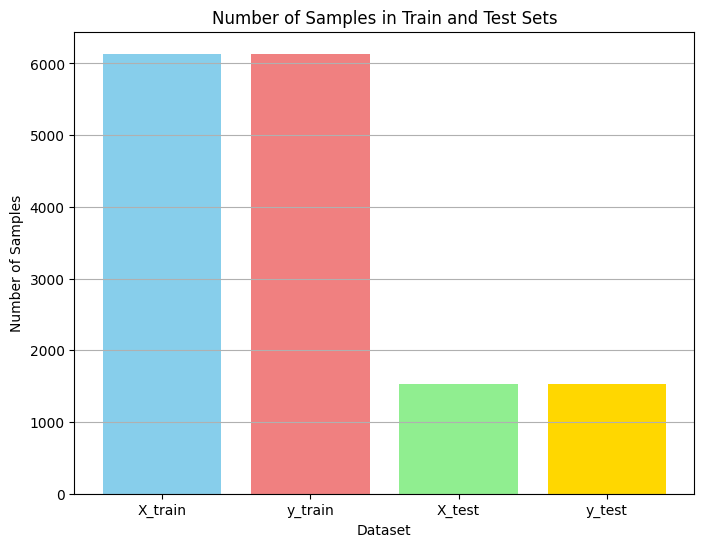

====== FINAL CHECK ======
Type X_train: <class 'numpy.ndarray'>, shape: (6138, 512, 1)
Type y_train: <class 'numpy.ndarray'>, shape: (6138, 5)
Type X_test: <class 'numpy.ndarray'>, shape: (1535, 512, 1)
Type y_test: <class 'numpy.ndarray'>, shape: (1535, 5)


In [15]:
# prepare_data_for_training.py

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# ===== Config paths =====

fusion_with_vector_csv = './dataset/fusion_with_vector_extended.csv'

# ===== Load dataset =====

try:
    df = pd.read_csv(fusion_with_vector_csv)
except Exception as e:
    print(f"Lỗi khi load fusion_with_vector_extended.csv: {e}")
    exit()

print(f"✅ Đã load {len(df)} dòng từ {fusion_with_vector_csv}")

# Chỉ giữ lại dòng có label hợp lệ
df = df[df['Label'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

# ===== Parse FusionVector từ chuỗi sang np.array =====

def parse_fusion_vector(vec_string):
    try:
        return np.fromstring(vec_string, sep=' ')
    except Exception as e:
        print(f"Error parsing fusion vector: {e}")
        return np.zeros(512)  # fallback nếu lỗi

df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

print("✅ Đã parse FusionVector thành np.array.")

# ===== Chuẩn bị X, y =====

# X là FusionVector, y là Label
X = np.stack(df['FusionVector_array'].values)
y_labels = df['Label'].values

print(f"✅ X có shape {X.shape}")
print(f"✅ y có shape {y_labels.shape}")

# ===== One-hot encode Label =====

lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

print(f"✅ Đã one-hot encode Label thành shape {y.shape}")

# ===== Reshape X cho CNN/BiLSTM =====

# Reshape (batch_size, 512, 1) cho 1D CNN hoặc BiLSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"✅ X sau reshape có shape {X.shape}")

# ===== Split train/test =====

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Đã chia dữ liệu: Train {X_train.shape[0]} samples, Test {X_test.shape[0]} samples.")

# ===== Visualization: Số lượng mẫu train/test =====

# Data for bar chart
data = {
    'Dataset': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Number of Samples': [X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]]
}

df_vis = pd.DataFrame(data)

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(df_vis['Dataset'], df_vis['Number of Samples'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Train and Test Sets')
plt.grid(axis='y')
plt.show()

# ===== In lại kiểm tra cuối =====

print("====== FINAL CHECK ======")
print(f"Type X_train: {type(X_train)}, shape: {X_train.shape}")
print(f"Type y_train: {type(y_train)}, shape: {y_train.shape}")
print(f"Type X_test: {type(X_test)}, shape: {X_test.shape}")
print(f"Type y_test: {type(y_test)}, shape: {y_test.shape}")


## train and evaluate model

2025-04-24 12:51:27.155490: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 12:51:27.163180: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 12:51:27.179356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745499087.206701  462915 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745499087.215579  462915 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745499087.236883  462915 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.3467 - loss: 1.7844 - val_accuracy: 0.5057 - val_loss: 1.3809
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.6406 - loss: 1.0016 - val_accuracy: 0.7622 - val_loss: 0.7288
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.7561 - loss: 0.7488 - val_accuracy: 0.8274 - val_loss: 0.6467
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.7985 - loss: 0.6333 - val_accuracy: 0.8754 - val_loss: 0.5487
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8041 - loss: 0.6369 - val_accuracy: 0.8575 - val_loss: 0.5321
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.8470 - loss: 0.5221 - val_accuracy: 0.8901 - val_loss: 0.4527
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.8180 - loss: 0.5670 - val_accuracy: 0.7875 - val_loss: 0.6210
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8391 - loss: 0

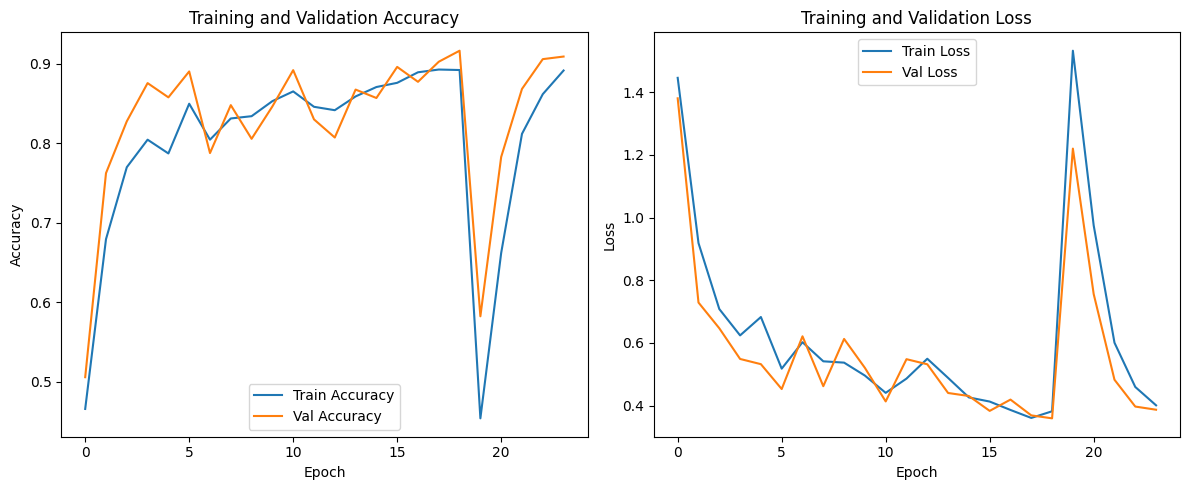

In [16]:
# ====== train_cnn_bilstm_attention.py ======

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels

# ===== Config =====
INPUT_SHAPE = (512, 1)   # Vì fusion vector có 512 chiều
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5
LEARNING_RATE = 1e-3

# ===== Build Model =====
def build_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    input_layer = Input(shape=input_shape)

    x = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))(x)

    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ===== Train Model =====
def train_model(model, X_train, y_train):
    early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stop],
                        verbose=1)
    return history

# ===== Evaluate Model =====
def evaluate_model(model, X_test, y_test, target_names):
    print("\n=== Evaluating Model ===")

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    if y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test

    precision = precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    acc = accuracy_score(y_test_labels, y_pred_labels)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

    print("\n=== Classification Report ===")
    labels_in_test = sorted(list(unique_labels(y_test_labels, y_pred_labels)))
    target_names_subset = [target_names[i] for i in labels_in_test]
    print(classification_report(y_test_labels, y_pred_labels, target_names=target_names_subset, digits=4, zero_division=0))

# ===== Plot Training Curves =====
def plot_training_curves(history):
    print("\n=== Plotting Training Curves ===")
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ===== Main Process =====
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('./dataset/fusion_with_vector_extended.csv')

    df = df[df['Label'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

    def parse_fusion_vector(vec_string):
        return np.fromstring(vec_string, sep=' ')

    df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

    X = np.stack(df['FusionVector_array'].values)
    y_labels = df['Label'].values

    lb = LabelBinarizer()
    y = lb.fit_transform(y_labels)

    X = X.reshape(X.shape[0], X.shape[1], 1)

    # --- Chia train/test có stratify để không mất lớp nhỏ ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y)

    target_names = lb.classes_.tolist()

    # Build, Train, Evaluate
    model = build_model()
    history = train_model(model, X_train, y_train)
    evaluate_model(model, X_test, y_test, target_names)
    plot_training_curves(history)


In [1]:
!date

Thu Apr 24 01:19:20 PM UTC 2025
